In [1]:
import pdb
import Model
import image
import loss
import importlib
importlib.reload(Model)
importlib.reload(image)
importlib.reload(loss)
from image import load_image, imshow, clip_pixel, tensor_to_image
from Model import Style_Extractor, Content_Extractor, features_maps_extractor
from loss import total_loss
from verbose import print_features_maps_content, print_features_maps_style
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False
import numpy as np
from tqdm import tqdm
from pprint import pprint
%matplotlib inline
import tensorflow as tf
import PIL.Image


2022-11-06 09:55:15.535642: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-06 09:55:15.535670: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


ImportError: cannot import name 'total_loss' from 'loss' (/home/widium/Programming/AI/Neural-Style-Transfer/loss.py)

In [128]:
# content = plt.imread('lion.png')
# style = plt.imread('vangogh.jpg')
#
# # Display the images
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
#
# # Content and style images side-by-side
# ax1.imshow(content)
# ax1.set_title('Content Image')
# ax2.imshow(style)
# ax2.set_title('Style Image')
# plt.show()

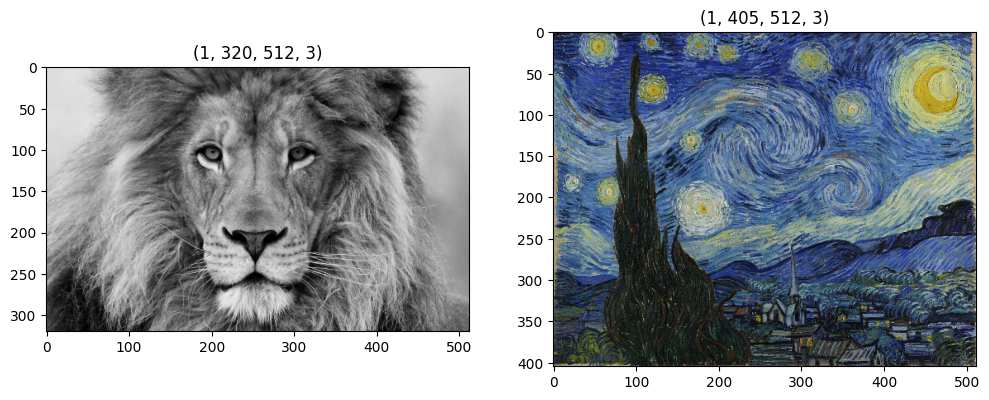

In [129]:
# Use load_image of content and style images
content_image = load_image('lion.jpg')
style_image = load_image('vangogh.jpg')

plt.subplot(1, 2, 1)
imshow(content_image, f'{content_image.shape}')

plt.subplot(1, 2, 2)
imshow(style_image, f'{style_image.shape}')

In [130]:
model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
model.trainable = False

In [131]:
Adam = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

STYLE_WEIGHT = 1e-2
CONTENT_WEIGHT = 1e3
# Content layer
content_layers = ['block5_conv2']

# Style layer
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [132]:
style_extractor = Style_Extractor(style_layers)
content_extractor = Content_Extractor(content_layers)

In [133]:
style_target = style_extractor(style_image)
content_target = content_extractor(content_image)

print_features_maps_style(style_target)
print_features_maps_content(content_target)

Style : 
 == block1_conv1  ==
  shape:  (1, 64, 64)
  min:  0.018298008
  max:  12683.961
  mean:  741.0306
 == block2_conv1  ==
  shape:  (1, 128, 128)
  min:  0.0
  max:  167520.25
  mean:  20790.137
 == block3_conv1  ==
  shape:  (1, 256, 256)
  min:  0.0
  max:  412942.8
  mean:  19077.05
 == block4_conv1  ==
  shape:  (1, 512, 512)
  min:  0.0
  max:  7943616.5
  mean:  272756.72
 == block5_conv1  ==
  shape:  (1, 512, 512)
  min:  0.0
  max:  112031.03
  mean:  1998.4756
Content : 
 == block5_conv2  ==
  shape:  (1, 20, 32, 512)
  min:  0.0
  max:  1373.4274
  mean:  13.745882


In [134]:
generated = tf.Variable(content_image)
generated.shape

TensorShape([1, 320, 512, 3])

In [135]:
style_target = style_extractor(style_image)
content_target = content_extractor(content_image)

style_generated = style_extractor(generated)
content_generated = content_extractor(generated)

## Gradient Descent

In [136]:
@tf.function()
def train_step(generated, style_target, content_target, num_style_layers):
  with tf.GradientTape() as tape:

        style_generated = style_extractor(generated)

        content_generated = content_extractor(generated)

        loss = total_loss(content_generated,
                      content_target,
                      style_generated,
                      style_target,
                      CONTENT_WEIGHT,
                      STYLE_WEIGHT,
                      num_style_layers)
  grad = tape.gradient(loss, generated)
  Adam.apply_gradients([(grad, generated)])
  generated = clip_pixel(generated.assign(generated))


## Test

In [137]:
train_step(generated, style_target, content_target, num_style_layers)
train_step(generated, style_target, content_target, num_style_layers)
train_step(generated, style_target, content_target, num_style_layers)

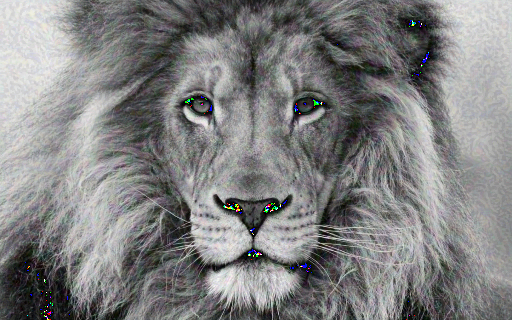

In [138]:
tensor_to_image(generated)